# Final Project Code Part 3 Improved AE On MNIST

**Name: Yiqun Hao**

**Content**: In this notebook:

1. I improved the code from the paper "Deep Learning for Case-Based Reasoning through Prototypes:A Neural Network that Explains Its Predictions" by applying a "push" operation in order to find samples that are the nearest to each prototype. Therefore, we don't need the autoencoder any more. 

2. I did experiments on MNIST to test its effectiveness and see comparisons.

#### Import all packages used in this notebook

In [1]:
# Main package: PyTorch
import torch
# TorchVision contains image datasets
import torchvision
# Our networks
import torch.nn as nn
# Our activation
import torch.nn.functional as F
# Optimizer
import torch.optim as optim

# Draw graphs to visualize
import matplotlib.pyplot as plt
import numpy as np

C:\Users\EZRA\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 0. Check GPU

In [2]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


#### CAE Model Parameters

In [3]:
# lambda's are the ratios between the four error terms
# lambda_class = 20
lambda_class = 10
lambda_1 = 1              # 1 and 2 here corresponds to the notation we used in the paper
lambda_2 = 1

# the number of prototypes
n_prototypes = 10

#### 1. We first import dataset

In [4]:
n_epochs = 5
batch_size = 100
# 0.01
learning_rate = 0.001
momentum = 0.5
random_seed = 1
torch.manual_seed(random_seed)

In [5]:
transform=torchvision.transforms.Compose([
    # To [0,1]
    torchvision.transforms.ToTensor(),
    # To [-1,1] first () is the mean of grey. Second () is the std of grey
    torchvision.transforms.Normalize(
    (0.1307,), (0.3081,))
])

train_set = torchvision.datasets.MNIST('./MNISTdataset/', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = torchvision.datasets.MNIST('./MNISTdataset/', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

#### 2. We construct our network 

##### 1. Encoder

In [6]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride = 2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride = 2)
        self.conv3 = nn.Conv2d(32, 10, kernel_size=3, stride = 2)

    def forward(self, x):
        # Input: 1 * 28 * 28 = 784
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
            #         10, 2 2
        x = F.relu(self.conv3(x))
        # New: Flatten layer
        #     print("x.shape: ", x.shape)
        x = x.view(-1, 10 * 2 * 2)
        #     print("feature_vectors.shape: ", feature_vectors.shape)
        return x
print(Encoder())

Encoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(32, 10, kernel_size=(3, 3), stride=(2, 2))
)


##### 2. Prototype Classification Network

In [7]:
# Functions used to calculate the distance between encoded_input and prototype vectors
def list_of_distances(X, Y):
    '''
    Given a list of vectors, X = [x_1, ..., x_n], and another list of vectors,
    Y = [y_1, ... , y_m], we return a list of vectors
            [[d(x_1, y_1), d(x_1, y_2), ... , d(x_1, y_m)],
             ...
             [d(x_n, y_1), d(x_n, y_2), ... , d(x_n, y_m)]],
    where the distance metric used is the sqared euclidean distance.
    The computation is achieved through a clever use of broadcasting.
    '''
    XX = list_of_norms(X).view(-1, 1)
    YY = list_of_norms(Y).view(1, -1)
    output = XX + YY - 2 * torch.matmul(X, Y.t())

    return output

def list_of_norms(X):
    '''
    X is a list of vectors X = [x_1, ..., x_n], we return
        [d(x_1, x_1), d(x_2, x_2), ... , d(x_n, x_n)], where the distance
    function is the squared euclidean distance.
    '''
    return torch.sum(torch.pow(X,2), axis=1)

In [8]:
class PCN(nn.Module):
    def __init__(self):
        super(PCN, self).__init__()
        self.prototype_feature_vectors = nn.Parameter(torch.rand(n_prototypes, 10*2*2))
        



# x.shape:  torch.Size([100, 10, 2, 2])
# feature_vectors.shape:  torch.Size([100, 40])
# prototype_feature_vectors.shape:  torch.Size([10, 40])
# feature_vector_distances.shape is the list of distances from each prototype to every x_i in the latent space:  torch.Size([10, 100])
# prototype_distances.shape is the list of distances from each x_i to every prototype in the latent space :  torch.Size([100, 10])
    def forward(self, feature_vectors):
        
        # ----------------------------------------------------------------------------------------------------------
        # Prototype layer
        prototype_distances = list_of_distances(feature_vectors, self.prototype_feature_vectors)
        feature_vector_distances = list_of_distances(self.prototype_feature_vectors, feature_vectors)



        # ----------------------------------------------------------------------------------------------------------
        # Fully-connected layer
        output = prototype_distances * -1
        return output, prototype_distances, feature_vector_distances, self.prototype_feature_vectors


    
print(PCN())

PCN()


In [9]:
class LastLayer(nn.Module):
    def __init__(self):
        super(LastLayer, self).__init__()
        self.fl = nn.Linear(n_prototypes, 10, bias=False)

    def forward(self, x):
        x = self.fl(x)
        return x
    def showWeight(self):
        print(self.fl.weight) 
print(LastLayer())

LastLayer(
  (fl): Linear(in_features=10, out_features=10, bias=False)
)


#### Overall Model

In [10]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.encoder = Encoder()
        self.pcn = PCN()
#         self.lastLayer = LastLayer()

    def forward(self, x):
        encoded_input = self.encoder(x)
        output, prototype_distances, feature_vector_distances, prototype_vectors = self.pcn(encoded_input)
#         output = self.lastLayer(output)
        return encoded_input, output, prototype_distances, feature_vector_distances, prototype_vectors
    
    def showWeight(self):
        self.lastLayer.showWeight()
    
    
print(MyModel())

MyModel(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
    (conv3): Conv2d(32, 10, kernel_size=(3, 3), stride=(2, 2))
  )
  (pcn): PCN()
)


#### Loss Function

In [11]:
'''
the error function consists of 4 terms, the autoencoder loss,
the classification loss, and the two requirements that every feature vector in
X look like at least one of the prototype feature vectors and every prototype
feature vector look like at least one of the feature vectors in X.
'''
class LossFunc(nn.Module):
    def __init__(self):
        super(LossFunc, self).__init__()
        self.crossLoss = nn.CrossEntropyLoss()

    def forward(self, outputs, labels, images, feature_vector_distances, prototype_distances):
        class_error = self.crossLoss(outputs,labels)
        error_2 = torch.mean(torch.min(prototype_distances, axis = 1).values)
        error_1 = torch.mean(torch.min(feature_vector_distances, axis = 1).values)
        total_error = lambda_class * class_error +\
                      lambda_1 * error_1 +\
                      lambda_2 * error_2
        return class_error, error_1, error_2, total_error 

#### 3. We train our network on training dataset and evaluate them on the test set

In [12]:
# 1. Initial networks
model = MyModel()
model = model.cuda()

# 3. Store things for visualizing results
accuracy_values=[]
total_loss_values=[]
error1_loss_values=[]
error2_loss_values=[]
class_loss_values=[]
epoch_number=range(n_epochs)



# 4. Begin training
criterion = LossFunc()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum) 

for epoch in epoch_number:
    running_loss = 0.0
    running_class = 0.0
    running_e1 = 0.0
    running_e2 = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        encoded_input, output, prototype_distances, feature_vector_distances, _ = model(inputs)
        class_error, error_1, error_2, total_error = criterion(output, labels, inputs, feature_vector_distances, prototype_distances)
        total_error.backward()
        optimizer.step()

        # print statistics
        running_loss += total_error.item()
        running_class += class_error.item()
        running_e1 += error_1.item()
        running_e2 += error_2.item()
    
        if i % 600 == 599:    # print every 6000 mini-batches (12500 batches in total)
            print('[epoch: %d, itr: %5d] total_loss: %.6f class_error: %.6f error_1: %.6f error_2: %.6f' %
                (epoch + 1, i + 1, running_loss/100, running_class/100, running_e1/100, running_e2/100))

            total_loss_values.append(running_loss/100)
            error1_loss_values.append(running_e1/100)
            error2_loss_values.append(running_e2/100)
            class_loss_values.append(running_class/100)

            running_loss = 0.0
            running_class = 0.0
            running_e1 = 0.0
            running_e2 = 0.0


    # Evaluate our dataset on test set
    correct = 0
    total = 0
#     model.showWeight()
    # Make parameters stay the same without updating
    with torch.no_grad():
      for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()

        encoded_input, output, prototype_distances, feature_vector_distances, prototype_vectors = model(images)
        # Return the value, index pair of the biggest element. Max function 1 means the biggest in each row, 0 means biggest in each column
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu()==labels.cpu()).sum().item()
        
      TestAccuracy = 100 * correct / total;
      accuracy_values.append(TestAccuracy) 
      print('Epoch=%d Test Accuracy=%.2f%%' %
                (epoch + 1, TestAccuracy))
    
    

print('Finished Here!')

[epoch: 1, itr:   600] total_loss: 58.617012 class_error: 3.679438 error_1: 8.229003 error_2: 13.593626
Epoch=1 Test Accuracy=92.26%
[epoch: 2, itr:   600] total_loss: 32.206739 class_error: 1.737800 error_1: 4.712844 error_2: 10.115895
Epoch=2 Test Accuracy=94.38%
[epoch: 3, itr:   600] total_loss: 26.265650 class_error: 1.363849 error_1: 3.746386 error_2: 8.880772
Epoch=3 Test Accuracy=95.33%
[epoch: 4, itr:   600] total_loss: 23.034644 class_error: 1.165050 error_1: 3.213016 error_2: 8.171127
Epoch=4 Test Accuracy=95.90%
[epoch: 5, itr:   600] total_loss: 20.942469 class_error: 1.042228 error_1: 2.853553 error_2: 7.666638
Epoch=5 Test Accuracy=96.18%
Finished Here!


#### Push each prototype to the closest sample 

In [13]:
closed_samples = [1000 for i in range(n_prototypes)]
closed_distances = [1000 for i in range(n_prototypes)]
closed_labels = ['label' for i in range(n_prototypes)]

with torch.no_grad():
    for _, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.cuda()
        labels = labels.cuda()
        if i == 0:
            print(inputs[0])
                
        _, _, _, feature_vector_distances, _ = model(inputs)
        feature_vector_distances = feature_vector_distances.cpu().tolist()
        
        # feature_vector_distances is the list of distances from each prototype to every x_i in the latent space torch.Size([10, 100])
        for i in range(n_prototypes):
            for j in range(len(feature_vector_distances[i])):
                if(feature_vector_distances[i][j] < closed_distances[i]):
                    closed_distances[i] = feature_vector_distances[i][j]
                    closed_samples[i] = inputs[j].cpu()
                    closed_labels[i] = labels[j].cpu()



#### Visualize prototypes

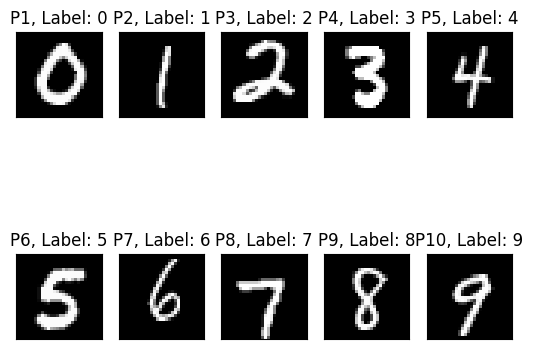

In [22]:
x = closed_samples
fig = plt.figure()
plt.subplots_adjust(hspace=0.5)
for i in range(n_prototypes):
    plt.subplot(2,n_prototypes//2,i+1)
    plt.imshow(x[i][0], cmap='gray', interpolation='none')
    plt.title("P{}, Label: {}".format(i+1, closed_labels[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

#### 5. Visualize our performance results

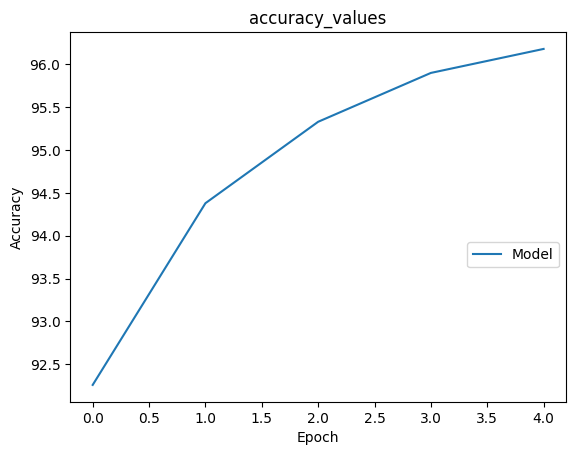

In [15]:
# First we check values we have so far
# print('accuracy_values', accuracy_values)
# print('epoch_number', epoch_number)
# Plot the data
plt.plot(epoch_number, accuracy_values, label='Model')  
plt.title('accuracy_values')
plt.xlabel('Epoch')#x轴
plt.ylabel('Accuracy')#y轴
# Add a legend
plt.legend(bbox_to_anchor=(1,0.45))

# Show the plot
plt.show()

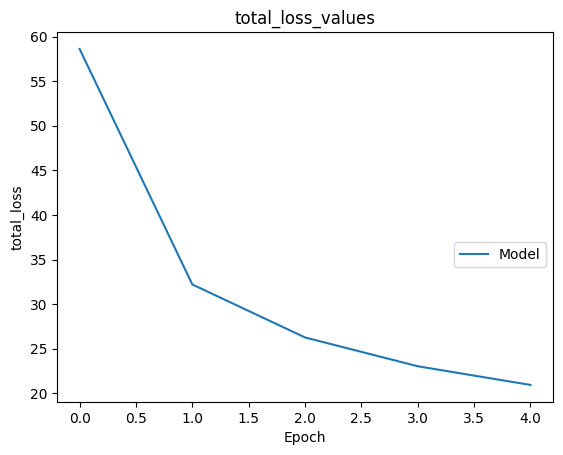

In [16]:
# Plot the data
plt.plot(epoch_number, total_loss_values, label='Model')  
plt.title('total_loss_values')
plt.xlabel('Epoch')#x轴
plt.ylabel('total_loss')#y轴
# Add a legend
plt.legend(bbox_to_anchor=(1,0.45))

# Show the plot
plt.show()

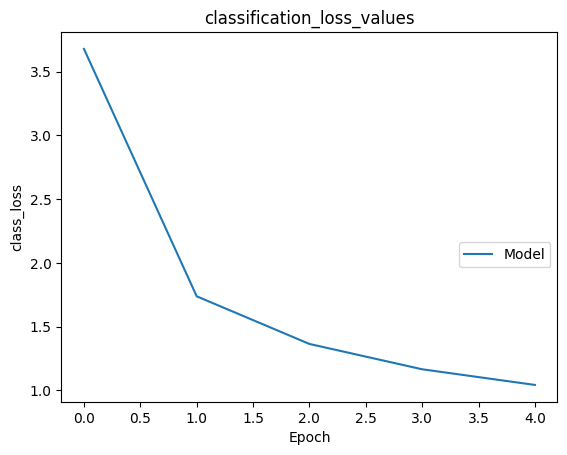

In [17]:
# Plot the data
plt.plot(epoch_number, class_loss_values, label='Model')  
plt.title('classification_loss_values')
plt.xlabel('Epoch')#x轴
plt.ylabel('class_loss')#y轴
# Add a legend
plt.legend(bbox_to_anchor=(1,0.45))

# Show the plot
plt.show()

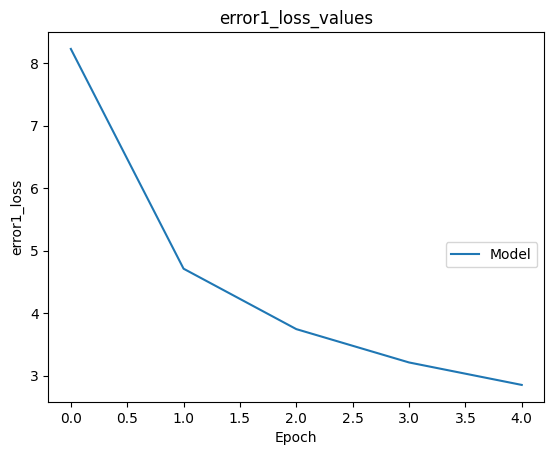

In [18]:
# Plot the data
plt.plot(epoch_number, error1_loss_values, label='Model')  
plt.title('error1_loss_values')
plt.xlabel('Epoch')#x轴
plt.ylabel('error1_loss')#y轴
# Add a legend
plt.legend(bbox_to_anchor=(1,0.45))

# Show the plot
plt.show()

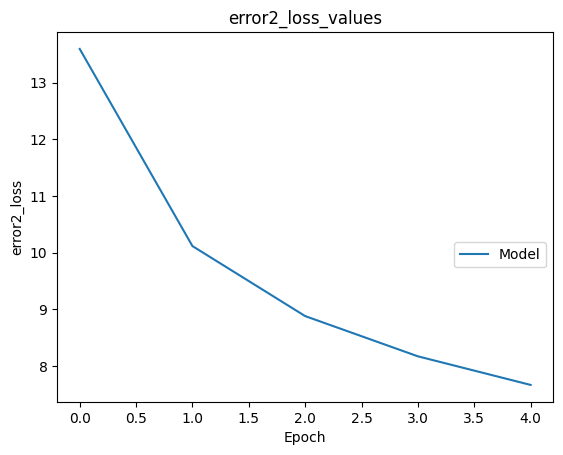

In [19]:
# Plot the data
plt.plot(epoch_number, error2_loss_values, label='Model')  
plt.title('error2_loss_values')
plt.xlabel('Epoch')#x轴
plt.ylabel('error2_loss')#y轴
# Add a legend
plt.legend(bbox_to_anchor=(1,0.45))

# Show the plot
plt.show()

#### Do more analysis on the final model to see how well it deals with each class

In [20]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
all_class_correct = list(0. for i in range(10))
all_class_total = list(0. for i in range(10))

with torch.no_grad():
    for images, labels in test_loader:
        images =images.cuda()
        labels =labels.cuda()
        _, outputs, _, _, _ = model(images)
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels)

        
        for i in range(batch_size):
            label = labels[i]
            all_class_correct[label] += c[i].item() # True is deemed as 1
            all_class_total[label] += 1



for i in range(10):
    print("all class total: ", all_class_total[i]," all class correct: ", all_class_correct[i])
    print('For network: Model Accuracy of %5s : %2d %%' % 
          (classes[i], 100 * all_class_correct[i] / all_class_total[i]))

all class total:  980.0  all class correct:  970.0
For network: Model Accuracy of     0 : 98 %
all class total:  1135.0  all class correct:  1127.0
For network: Model Accuracy of     1 : 99 %
all class total:  1032.0  all class correct:  974.0
For network: Model Accuracy of     2 : 94 %
all class total:  1010.0  all class correct:  956.0
For network: Model Accuracy of     3 : 94 %
all class total:  982.0  all class correct:  947.0
For network: Model Accuracy of     4 : 96 %
all class total:  892.0  all class correct:  855.0
For network: Model Accuracy of     5 : 95 %
all class total:  958.0  all class correct:  923.0
For network: Model Accuracy of     6 : 96 %
all class total:  1028.0  all class correct:  973.0
For network: Model Accuracy of     7 : 94 %
all class total:  974.0  all class correct:  936.0
For network: Model Accuracy of     8 : 96 %
all class total:  1009.0  all class correct:  957.0
For network: Model Accuracy of     9 : 94 %


#### Visualize the performance on each class

all_class_correct [98.9795918367347, 99.29515418502203, 94.37984496124031, 94.65346534653466, 96.43584521384929, 95.85201793721973, 96.34655532359082, 94.64980544747081, 96.09856262833675, 94.84638255698711]


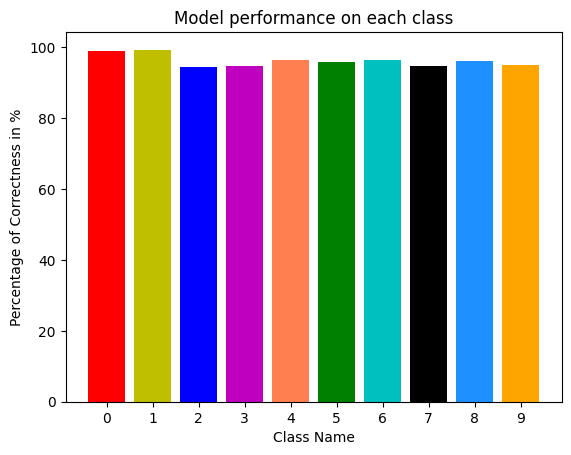

In [21]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

for i, x in enumerate(all_class_correct):
    all_class_correct[i] = 100 * all_class_correct[i] / all_class_total[i]
print('all_class_correct', all_class_correct)


plt.bar(classes, all_class_correct, color=['r','y','b','m','coral','g','c','k','dodgerblue','orange'])
plt.title('Model performance on each class')
plt.xlabel('Class Name')#x轴
plt.ylabel('Percentage of Correctness in %')#y轴

plt.show()